- **Objective:** To classify faces in photo images using Principle Component Analysis (PCA) 
- **Instruction Material:** Located in \Instruction\ 
- **Data:** Images located in \Reference_Files\
- **Good Read:**:
    - https://en.wikipedia.org/wiki/Eigenface
    - http://jmcspot.com/Eigenface/
    - https://www.bytefish.de/pdf/facerec_python.pdf
    - http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
    - http://arnauddelorme.com/ica_for_dummies/
    - http://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm
    - http://setosa.io/ev/principal-component-analysis/

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

['14.jpg', '2.jpg', '13.jpg', '5.jpg', '12.jpg', '4.jpg', '3.jpg', '9.jpg', '11.jpg', '7.jpg', '10.jpg', '6.jpg', '1.jpg', '8.jpg']
14
14
(300, 300)
float64


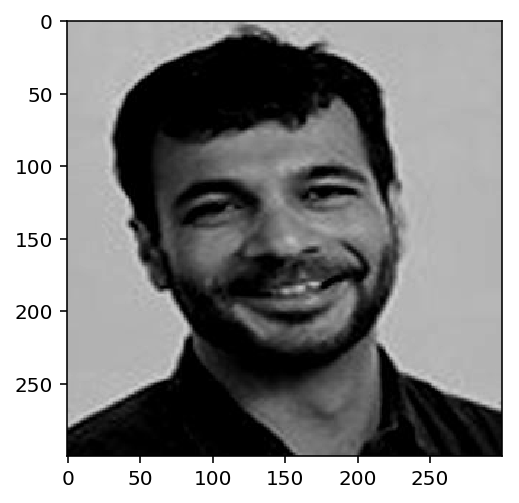

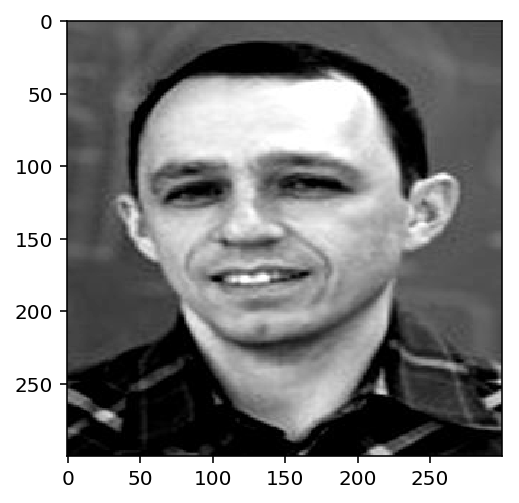

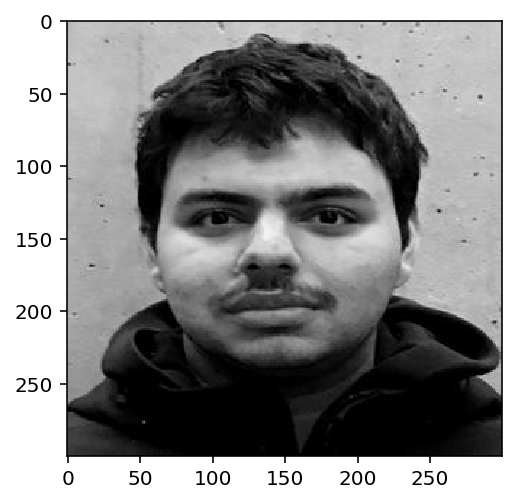

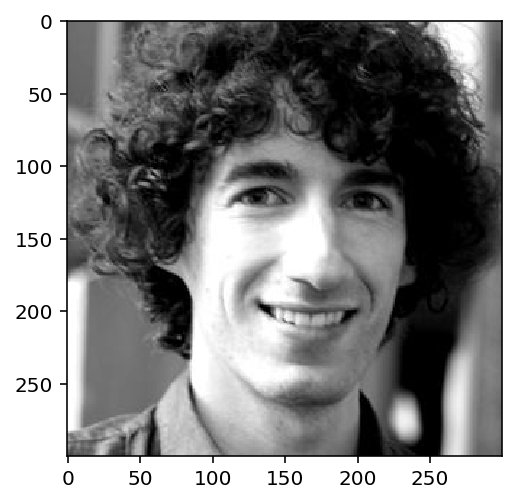

In [2]:
# look for all images files, aka data, in the Reference_File folder
oim_files = os.listdir('Reference_Files')
print(oim_files)
image_count = len(oim_files)
print(image_count) # number of images

# open images, convert to grayscale and resize to 300x300
im = [np.array(Image.open( '/'.join( ["Reference_Files", img] )).convert('L').resize((300,300),Image.ANTIALIAS), dtype=float) for img in oim_files]
print(len(im))
print(im[0].shape)
print(im[0].dtype)

# let's have a peek of our first 4 images
for i in range(4):
    plt.imshow(im[i], cmap='gray', vmin = 0, vmax = 255)
    plt.show()

---
First of all, flattern each image to a row of pixels, then tranpose it as an "image vector"

---

In [3]:
# flatten

# matrix S will store all images with each column represent each flattened image
S = np.zeros((14, 300*300), dtype=float)
for i, imm in enumerate(im):
    # now this is a 1 by 300x300 row
    im_row = imm.flatten()
    S[i,:] = im_row 
S = S.T

print(S.shape)
print(S.dtype)

(90000, 14)
float64


---
Then we calculate the Mean Face

---

(90000,)


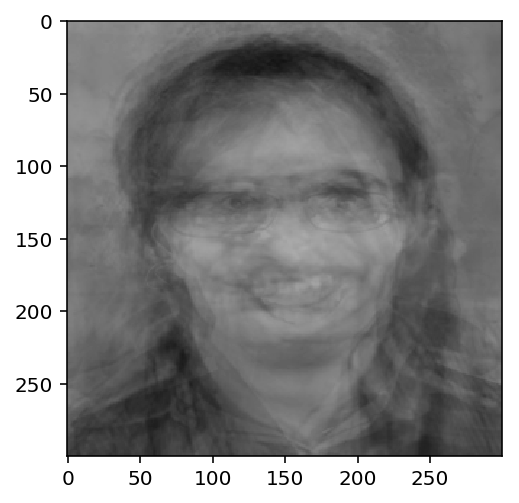

In [4]:
# calculate the "mean" face for all (14) images  :p the mean face -> .\_/.
# which is pretty much a column vector (300*300 by 1) for each element is the mean of each row
mean_face = np.mean(S, axis=1) # to take the mean of each row 
print(mean_face.shape)

# let's take a peek of the mean_face
plt.imshow(mean_face.reshape(300,300), cmap='gray', vmin = 0, vmax = 255)

---
Substract each image columns in S by the Mean Face, result matrix is a 300*300 by 14 matrix SS

---

14
(90000, 14)
(90000, 14)


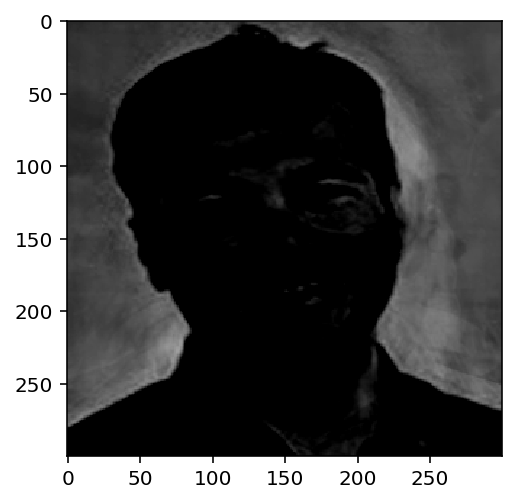

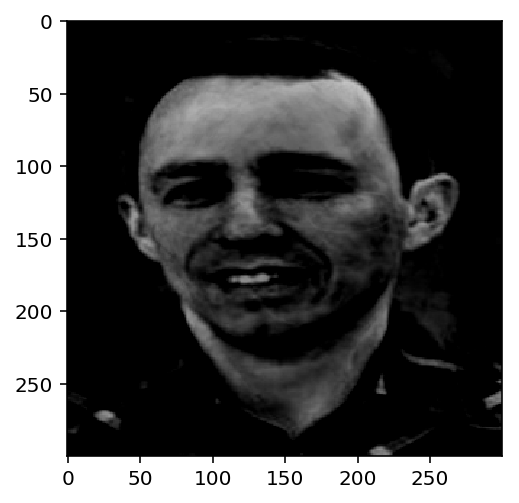

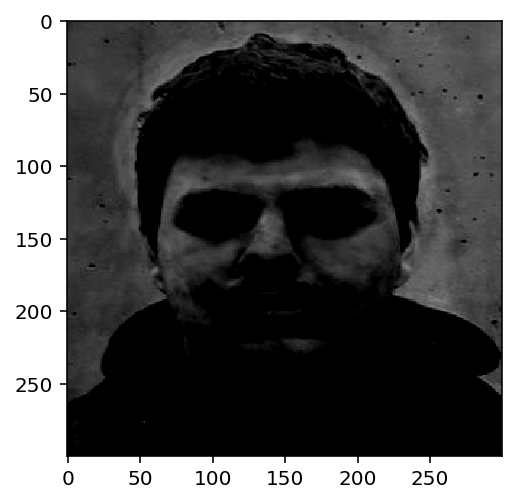

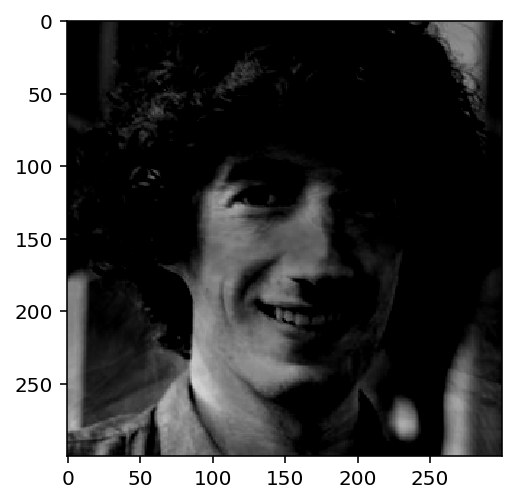

In [5]:
print(S.shape[1])
mf = np.atleast_2d(mean_face).T
mean_face_matrix = np.repeat(mf, S.shape[1], axis=1)
print(mean_face_matrix.shape)

SS = S - mean_face_matrix
print(SS.shape)

# Let's take a peek of the first 4 Diff Face
for i in range(4):
    diff_face = SS[:,i]
    plt.imshow(diff_face.reshape(300,300), cmap='gray', vmin = 0, vmax = 255)
    plt.show()

---
Find the Covariance Matrix from SS and the EigenVectors and corresponding EigenValues; Sort the EigenValues

---

In [6]:
# numpy.cov requires each row of the 3D matrix a variable, thus each column is a observation
# Our SS matrix fits perfectly for this purpose. Each row of SS matrix is a pixel, a feature, aka variable
#cov_SS = np.cov(SS) # this should result in a 300*300 by 300*300 matrix
#print(cov_SS.shape)
# Let C be the Covariance Matrix, and L be the smaller version
# C will be a 90000 by 90000 matrix, and L will be a 14 by 14 matrix !!!

L = np.dot(SS.T,SS)
print(L.shape)

[eigenvalues, temp_eigenvectors] = np.linalg.eigh(L)

# each real eigenvector should be a len of 90000 vector
eigenvectors = np.dot(SS, temp_eigenvectors)
print(eigenvectors.shape)
# the real eigenvectors need to be normalized
for i in range(eigenvectors.shape[1]):
    eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
# make sure we don't lose any eigenvectors
print(eigenvectors.shape)


(14, 14)
(90000, 14)
(90000, 14)


In [7]:
# let's peek at our eigenvalues
print(eigenvalues)
# sort the eigenvalues and get the index, sort by the descending order
idx = np.argsort(eigenvalues)
print(idx)
idx = np.flipud(idx)
print(idx)

[ -2.63157688e-07   1.23180883e+08   1.35171613e+08   1.58125010e+08
   1.69434964e+08   2.10940014e+08   2.60464982e+08   2.96548784e+08
   3.48604143e+08   3.67269140e+08   5.81637432e+08   6.43121077e+08
   9.74513582e+08   1.85506136e+09]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[13 12 11 10  9  8  7  6  5  4  3  2  1  0]


In [8]:
# say, we only want the 10 most significant component
N = 10
eigenV = eigenvectors[:,idx[:10]]
print(eigenV.shape) # we should see 90000 by 10 

(90000, 10)


(90000, 10)

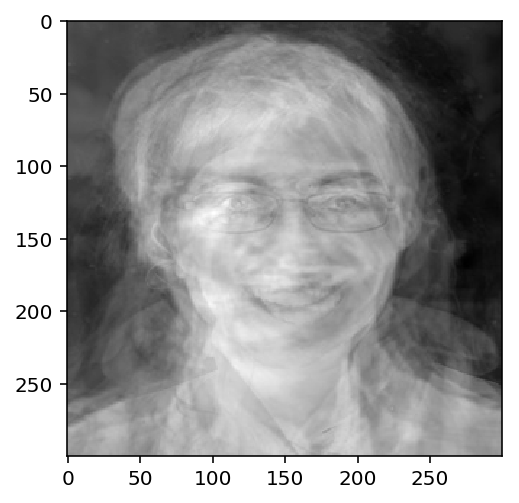

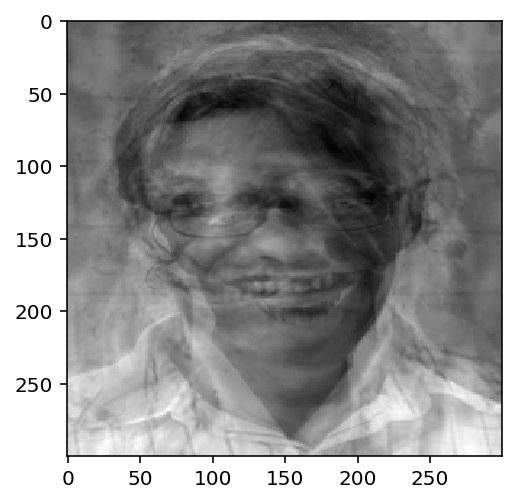

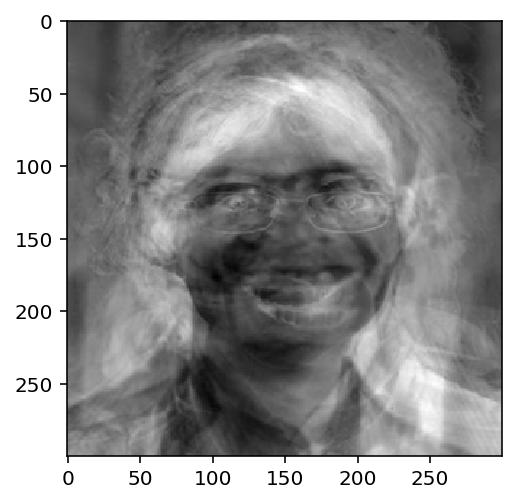

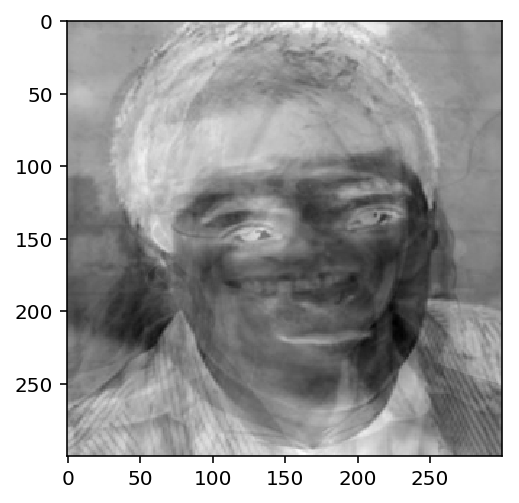

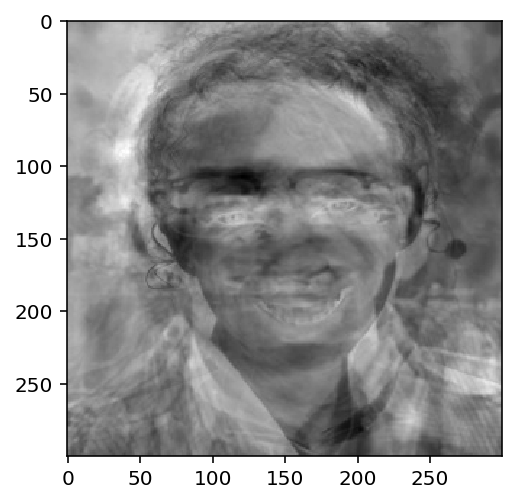

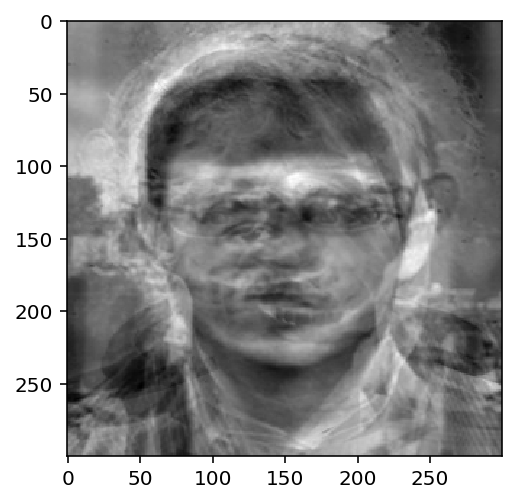

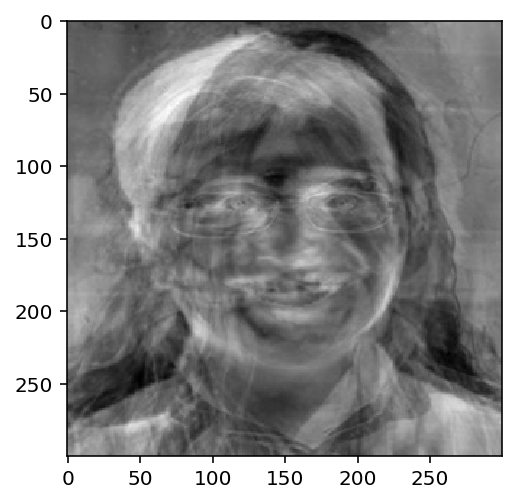

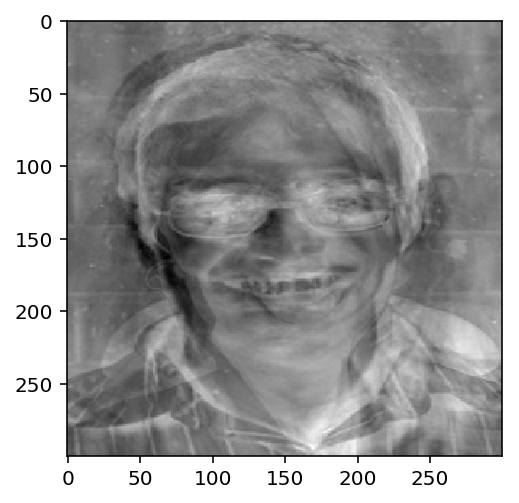

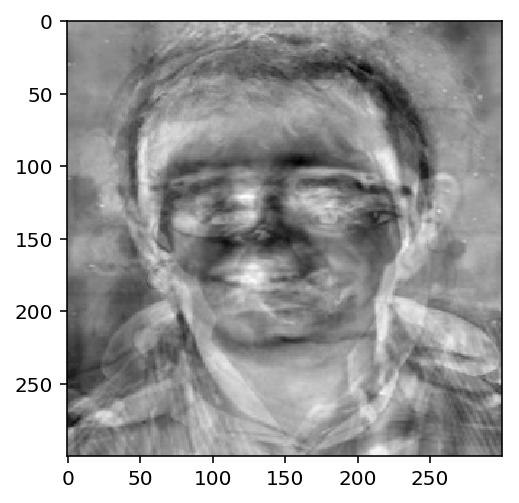

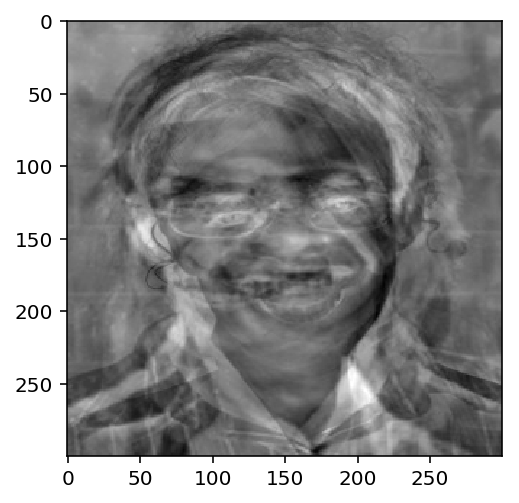

In [9]:
# Let's take a peek of our 10 eigenface

# normalize (0..1) and scale the eigenvector to a readable color range (0..255)
for i in range(N):
    emin = np.min(eigenV[:,i])
    emax = np.max(eigenV[:,i])
    eigenV[:,i] = ( (eigenV[:,i]-emin) / (emax-emin) ) *255

print(eigenV.shape)

for i in range(N):
    eigen_face = eigenV[:,i]
    plt.imshow(eigen_face.reshape(300,300), cmap='gray', vmin = 0, vmax = 255)
    plt.show()


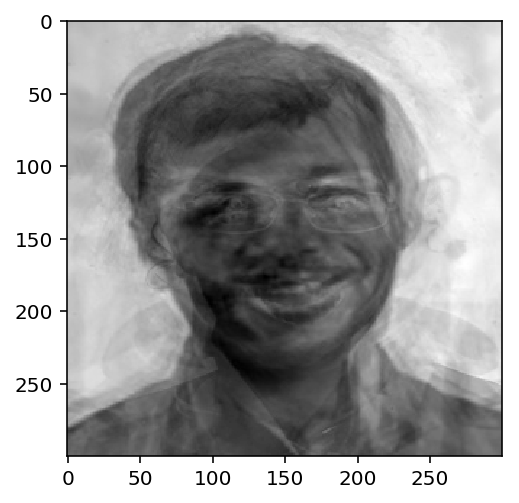

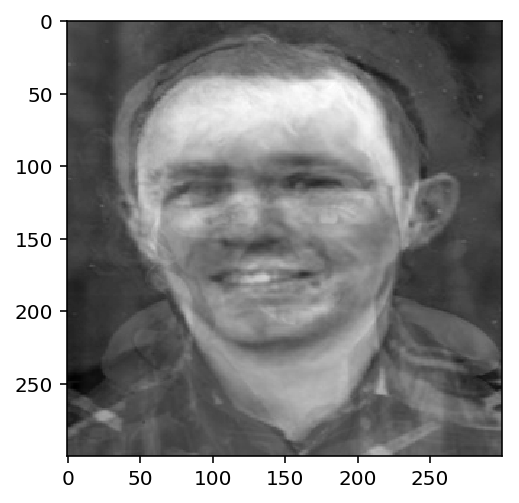

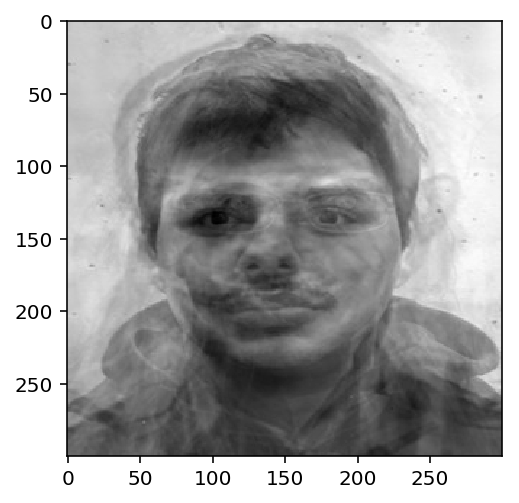

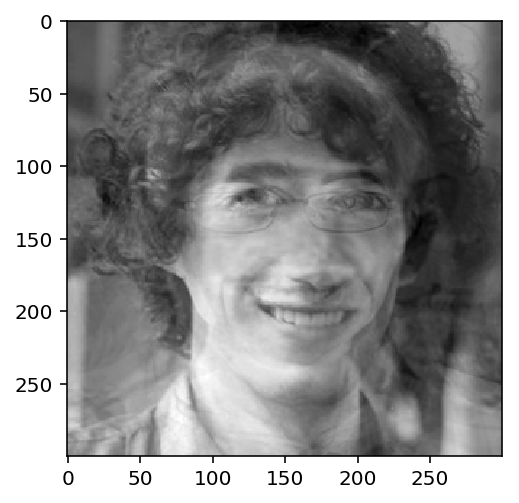

In [10]:
# Now let's try to reconstruct the first 4 faces using our 10 eigenfaces

Y = np.dot(eigenV.T, SS) # Y is 10 by 14 array
X = np.dot(eigenV, Y) + mean_face_matrix # X is 900000 by 14 array

# normalize and scale the faces
for i in range(X.shape[1]):
    Xmin = np.min(X[:,i])
    Xmax = np.max(X[:,i])
    X[:,i] = ( (X[:,i]-Xmin) / (Xmax-Xmin) ) *255

for i in range(4):
    face = X[:,i]
    plt.imshow(face.reshape(300,300), cmap='gray', vmin = 0, vmax = 255)
    plt.show()
